# NAMED ENTITY RECOGNITION USING BI-LSTM

### IMPORTING LIBRARIES:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

### IMPORTING DATA:

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding = 'latin1')
data.fillna(method = 'ffill', inplace = True)
data.head().append(data.tail())

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [3]:
data.shape

(1048575, 4)

In [4]:
data.drop(['POS'], axis = 1, inplace = True)

In [5]:
print(f'No.of Unique Words:{data.Word.nunique()}')
print(f'No.of Unique Tags:{data.Tag.nunique()}')

No.of Unique Words:35168
No.of Unique Tags:17


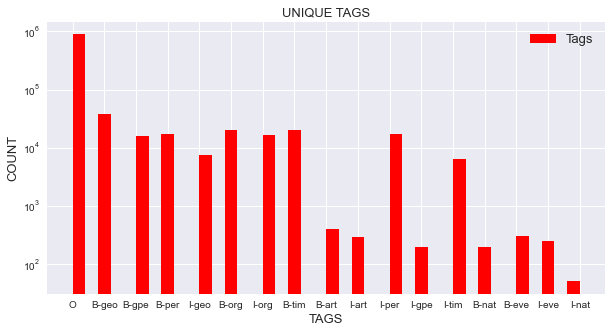

In [6]:
plt.figure(figsize = (10, 5))
plt.style.use('seaborn')
plt.hist(data.Tag, log = True, bins = 40, label = 'Tags', color = 'red')
plt.title('UNIQUE TAGS', fontsize = 13)
plt.xlabel('TAGS', fontsize = 13)
plt.ylabel('COUNT', fontsize = 13)
plt.legend(fontsize = 13)
plt.show()

### GROUPING WORDS AND TAGS:

In [7]:
words = list(set(data['Word'].values))
num_words = len(words)
tags = list(set(data['Tag'].values))
n_tags = len(tags)
print(num_words, n_tags)

35168 17


In [8]:
class Grouping:
    
    def __init__(self, data):
        self.data = data
        self.empty = False
        agg_fun = lambda S : [(w, t) for w, t in zip(S['Word'].values.tolist(),
                                                     S['Tag'].values.tolist())]
        self.group = self.data.groupby('Sentence #').apply(agg_fun)
        self.sentence = [sen for sen in self.group]

In [9]:
getter = Grouping(data)
sentences = getter.sentence

In [10]:
sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

### MAPPING WORDS AND TAGS TO INDEX:

In [11]:
word2idx = {w : i + 1 for i, w in enumerate(words)}
tag2idx = {t : i for i, t in enumerate(tags)}

In [12]:
word2idx

{'Genoese': 1,
 'Pinochet': 2,
 'million-dollar': 3,
 '1953': 4,
 'Era': 5,
 'pretax': 6,
 'karate': 7,
 'non-farm': 8,
 'aspect': 9,
 'Sanader': 10,
 'Holmes': 11,
 'Pallipat': 12,
 'commodies': 13,
 'invalidate': 14,
 'Perkins': 15,
 'ozone': 16,
 'remote-controlled': 17,
 'Voters': 18,
 'encouraged': 19,
 'Warren': 20,
 'A.D.': 21,
 'Reference': 22,
 'whipping': 23,
 'payloads': 24,
 'Mohmmed': 25,
 'stir': 26,
 'repercussions': 27,
 'hydrocarbons': 28,
 'break': 29,
 'mid-June': 30,
 'AQUINO': 31,
 'prevent': 32,
 'cracking': 33,
 'applause': 34,
 '1996': 35,
 'KHANAL': 36,
 '1983': 37,
 'CNN-IBN': 38,
 'farthest': 39,
 'heretic': 40,
 'siege': 41,
 'Hyung-taik': 42,
 'slave': 43,
 'visa': 44,
 'Marseille': 45,
 'DOE': 46,
 'parades': 47,
 'club': 48,
 'blocking': 49,
 'Velasco': 50,
 'Newport': 51,
 'Closing': 52,
 'Registry': 53,
 'Mosque': 54,
 'HARES': 55,
 '27,000': 56,
 'Clarence': 57,
 'fostering': 58,
 'Defending': 59,
 'stint': 60,
 'Successful': 61,
 'Abass': 62,
 'invade

In [13]:
tag2idx

{'I-nat': 0,
 'B-gpe': 1,
 'B-geo': 2,
 'I-tim': 3,
 'B-per': 4,
 'B-org': 5,
 'I-gpe': 6,
 'B-nat': 7,
 'I-per': 8,
 'B-tim': 9,
 'O': 10,
 'I-art': 11,
 'I-eve': 12,
 'B-art': 13,
 'B-eve': 14,
 'I-org': 15,
 'I-geo': 16}

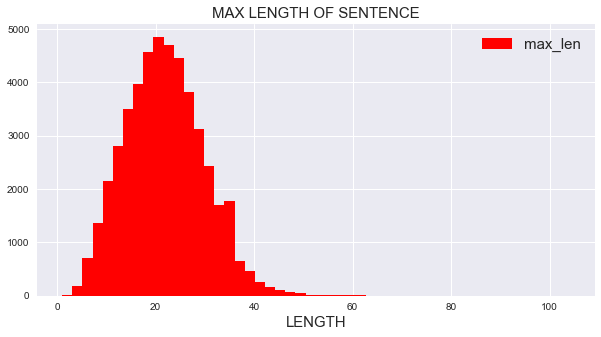

In [14]:
plt.figure(figsize = (10, 5))
plt.hist([len(s) for s in sentences], color = 'red', label = 'max_len', bins = 50)
plt.title('MAX LENGTH OF SENTENCE',fontsize = 15)
plt.xlabel('LENGTH', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

- HERE WE CAN SEE THAT THE MAX LENGTH REACHES 60

### PADDING WORDS AND TAGS:

In [15]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [16]:
max_len = 60
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(X, maxlen = max_len, padding = 'post', value = num_words - 1)
y = [[tag2idx[t[1]] for t in s] for s in sentences]
y = pad_sequences(y, maxlen = max_len, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes = n_tags) for i in y]

### SPLITTING THE DATA FOR TRAINING AND TESTING:

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 44)

In [18]:
X_train.shape, X_test.shape

((38367, 60), (9592, 60))

In [19]:
print(len(y_train), len(y_test))

38367 9592


### DEFINING BI-LSTM:

In [20]:
input_dim = num_words + 1 #model.fit() iterates through the input with the range(0:35178). Thus we are adding 1 to fullfil the range(0:35179).
output_dim = max_len
input_length = max_len

In [21]:
input_dim, output_dim, input_length

(35169, 60, 60)

In [22]:
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.layers import Bidirectional, TimeDistributed, SpatialDropout1D

In [23]:
model = Sequential()

model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length))

model.add(SpatialDropout1D(0.1))

model.add(Bidirectional(LSTM(units = 100, recurrent_dropout = 0.1, return_sequences = True)))

model.add(TimeDistributed(Dense(units = n_tags, activation = 'softmax')))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 60)            2110140   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 60)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          128800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 60, 17)           3417      
 ibuted)                                                         
                                                                 
Total params: 2,242,357
Trainable params: 2,242,357
Non-trainable params: 0
______________________________________________

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 1, mode = 'max', restore_best_weights = True)

history = model.fit(X_train, np.array(y_train), batch_size = 32, validation_split = 0.1, epochs = 10, callbacks = callbacks, verbose = 1)

Epoch 1/10
1080/1080 [==============================] - 109s 98ms/step - loss: 0.1580 - accuracy: 0.9644 - val_loss: 0.0530 - val_accuracy: 0.9846
Epoch 2/10
1080/1080 [==============================] - 125s 116ms/step - loss: 0.0435 - accuracy: 0.9872 - val_loss: 0.0409 - val_accuracy: 0.9878
Epoch 3/10
1080/1080 [==============================] - 125s 115ms/step - loss: 0.0314 - accuracy: 0.9905 - val_loss: 0.0386 - val_accuracy: 0.9884
Epoch 4/10
1080/1080 [==============================] - 123s 114ms/step - loss: 0.0256 - accuracy: 0.9920 - val_loss: 0.0396 - val_accuracy: 0.9881
Epoch 5/10
1080/1080 [==============================] - 116s 107ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.0406 - val_accuracy: 0.9882
Epoch 5: early stopping


In [25]:
model.save('./NER_MODEL_KAGGLE.h5')

In [26]:
model.evaluate(X_test, np.array(y_test))

300/300 [==============================] - 5s 16ms/step - loss: 0.0409 - accuracy: 0.9878


[0.04094551131129265, 0.9877867102622986]

### ACCURACY AND LOSS OF THE MODEL:

Text(0.5, 1.0, 'Accuracy Curves')

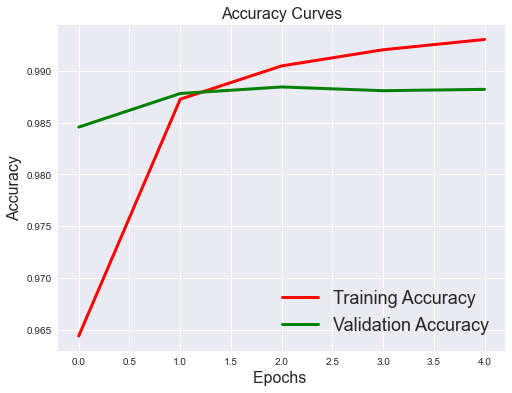

In [27]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'g',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

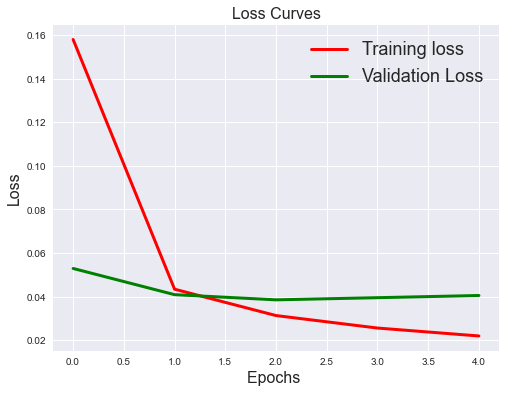

In [28]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'g',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### TESTING THE NER MODEL:

In [29]:
i = np.random.randint(0,X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis =-1)
y_true = np.argmax(np.array(y_test), axis =-1)[i]
print("{:15}{:5}\t {} \n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(X_test[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred]))

Word           True 	 Pred 

------------------------------
He             O	O
has            O	O
pleaded        O	O
not            O	O
guilty         O	O
to             O	O
all            O	O
of             O	O
the            O	O
charges        O	O
from           O	O
the            O	O
Tanzania-based O	O
court          O	O
.              O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brokered  O	O
U.N.-brok

In [33]:
from future.utils import iteritems
tags = list(set(data["Tag"].values))
number_tags = len(tags)

tag2idx = {t: i+1 for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in iteritems(tag2idx)}

In [40]:
#Evaluating the model
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test))  
print(classification_report(np.argmax(y_test, -1).ravel(), 
                            np.argmax(y_pred, axis=-1).ravel(),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

       I-nat       0.95      0.94      0.95      3160
       B-gpe       0.85      0.88      0.87      7550
       B-geo       0.85      0.73      0.78      1247
       I-tim       0.83      0.81      0.82      3361
       B-per       0.83      0.65      0.73      4067
       B-org       1.00      0.38      0.56        52
       I-gpe       0.00      0.00      0.00        38
       B-nat       0.86      0.85      0.85      3448
       I-per       0.91      0.87      0.89      3997
       B-tim       0.99      1.00      1.00    543413
           O       0.00      0.00      0.00        55
       I-art       1.00      0.02      0.04        49
       I-eve       0.00      0.00      0.00        71
       B-art       0.88      0.21      0.34        70
       B-eve       0.82      0.72      0.77      3442
       I-org       0.78      0.78      0.78      1486
       I-geo       0.00      0.00      0.00         0

   micro avg       0.99   